In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import warnings

# Import API key
from ba_config import g_key

# Ignore unnecessary gmaps warning
warnings.filterwarnings('ignore')

In [6]:
# Read in original CSV as new dataframe
crime_df = pd.read_csv("NYC_Crime_October_2014.csv")
crime_df.head()

,ARREST_DATE,PD_DESC,OFNS_DESC,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
0,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,WHITE HISPANIC,40.731668,-73.989415
1,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,18-24,M,WHITE HISPANIC,40.864328,-73.868406
2,10/31/14,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,25-44,F,BLACK,40.671111,-73.913563
3,10/31/14,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,18-24,F,BLACK,40.648867,-73.950822
4,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,BLACK,40.717115,-73.920426


In [3]:
# Find the closest fast food restaurant to each set of coordinates
# ----------------------------------
# *Do not run cell again as to avoid overcharge and massive time delay
# *Instead just refer to restaurants.csv for results of this cell's code
# ----------------------------------

# Google API used to find nearby restaurants
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

# Set parameters for the API url
params = {
    "rankby": "distance",
    "types": "restaurant",
    "keyword": "fast food",
    "key": g_key
}

# Loop through entire dataframe to retrieve closest restaurant to each set of coordinates
for index, row in crime_df.iterrows():
    
    # get coordinates from dataframe
    lat = row["Latitude"]
    lng = row["Longitude"]

    # change location each iteration while leaving original params in place
    params["location"] = f"{lat},{lng}"

    # make request
    name_address = requests.get(base_url, params=params)

    # convert and reassign variable to json
    name_address = name_address.json()

    # Since some data may be missing we incorporate a try-except to skip any that are missing a data point
    # Add results of the API call as colums to crime_df
    try:
        crime_df.loc[index, "Closest Restaurant"] = name_address["results"][0]["name"]
        crime_df.loc[index, "Restaurant Address"] = name_address["results"][0]["vicinity"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

In [4]:
# View dataframe resulting from API call in previous cell
crime_df.head()

,ARREST_DATE,PD_DESC,OFNS_DESC,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Closest Restaurant,Restaurant Address
0,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,WHITE HISPANIC,40.731668,-73.989415,Chick-fil-A,"5 University Pl, New York"
1,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,18-24,M,WHITE HISPANIC,40.864328,-73.868406,McDonald's,"2516 White Plains Rd, The Bronx"
2,10/31/14,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,25-44,F,BLACK,40.671111,-73.913563,KFC,"1667 Pitkin Ave, Brooklyn"
3,10/31/14,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,18-24,F,BLACK,40.648867,-73.950822,Burger King,"2848 Church Ave, Brooklyn"
4,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,BLACK,40.717115,-73.920426,Popeyes Louisiana Kitchen,"259 Vandervoort Ave, Brooklyn"


In [5]:
# Export New Dataframe to CSV
crime_df.to_csv("restaurants.csv", index=False)

In [2]:
# Read in CSV as dataframe to use for all further analysis
restaurants_df = pd.read_csv("restaurants.csv")
restaurants_df.head()

,ARREST_DATE,PD_DESC,OFNS_DESC,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Closest Restaurant,Restaurant Address
0,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,WHITE HISPANIC,40.731668,-73.989415,Chick-fil-A,"5 University Pl, New York"
1,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,18-24,M,WHITE HISPANIC,40.864328,-73.868406,McDonald's,"2516 White Plains Rd, The Bronx"
2,10/31/14,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,25-44,F,BLACK,40.671111,-73.913563,KFC,"1667 Pitkin Ave, Brooklyn"
3,10/31/14,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,18-24,F,BLACK,40.648867,-73.950822,Burger King,"2848 Church Ave, Brooklyn"
4,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,BLACK,40.717115,-73.920426,Popeyes Louisiana Kitchen,"259 Vandervoort Ave, Brooklyn"


In [3]:
# Drop unnecessary columns from dataframe
by_address = restaurants_df[['Closest Restaurant', 'Restaurant Address','Latitude','Longitude']]

# Isolate the 10 (or however many desired) specific restaurants (by address, not franchise)
# with the highest number of nearby crimes, from highest to lowest
# ----------------------------------
# *Note - .value_counts() only creates a dataframe that consists of a single series
# which must be merged into original dataframe afterword
# ----------------------------------
top_ten = pd.DataFrame(by_address['Restaurant Address'].value_counts().head(10))
top_ten = top_ten.reset_index()
top_ten.columns = ['Restaurant Address', 'Number of Crimes']

# Merge top ten restaurants with their nearby crime counts with original dataframe
top_ten = pd.merge(top_ten,restaurants_df,on='Restaurant Address')

# Drop all unnecessary columns after merge and organize new dataframe
top_ten = top_ten[['Closest Restaurant','Restaurant Address','Latitude','Longitude','Number of Crimes']]
top_ten.rename(columns ={'Closest Restaurant':'Restaurant',
                         'Restaurant Address':'Address'})

# Only show each restaurant once
top_ten = top_ten.drop_duplicates(subset = 'Restaurant Address').reset_index()

# Drop column with original indeces
del top_ten['index']

# View resulting dataframe
top_ten

,Closest Restaurant,Restaurant Address,Latitude,Longitude,Number of Crimes
0,White Castle,"3101 Atlantic Ave, Brooklyn",40.671412,-73.881512,67
1,Kennedy Chicken And Pizza,"2041 Grand Concourse, The Bronx",40.853587,-73.900591,63
2,Texas Chicken & Burgers,"2660 3rd Ave, The Bronx",40.812200,-73.930229,62
3,White Castle,"1677 Bruckner Blvd, The Bronx",40.823387,-73.870170,55
4,Kennedy fried chicken,"381 Bedford Park Blvd, The Bronx",40.869407,-73.879998,53
5,Hyderi Fast Food Inc,"4049 Laconia Ave, The Bronx",40.885846,-73.845839,53
6,KFC,"1667 Pitkin Ave, Brooklyn",40.671111,-73.913563,51
7,McDonald's,"875 Garrison Ave, The Bronx",40.804013,-73.878332,48
8,Coffee cosina,"1350 Jerome Ave, The Bronx",40.837782,-73.919458,48
9,McDonald's,"2870 3rd Ave, The Bronx",40.822298,-73.911694,42


In [88]:
# Configure gmaps
gmaps.configure(api_key=g_key)

# Template for map markers
info_box_template = """
<dl>
<dt>Restaurant</dt><dd>{Closest Restaurant}</dd>
<dt>Address</dt><dd>{Restaurant Address}</dd>
<dt>Number of Crimes Nearby</dt><dd>{Number of Crimes}</dd>
</dl>
"""

# Assign variable to dataframe row to use on markers
restaurant_info = [info_box_template.format(**row) for index, row in top_ten.iterrows()]

# Assign variable for marker layer to dataframe coordinates
locations = top_ten[["Latitude", "Longitude"]]

# Display map
fig = gmaps.figure()

# Assign and add marker layer including restaurant information
marker_layer = gmaps.marker_layer(locations, info_box_content=restaurant_info)
fig.add_layer(marker_layer)

# Display Map with clickable marker info boxes
fig

Figure(layout=FigureLayout(height='420px'))

In [181]:
# Combine duplicate restaurants that are labeled differently
restaurants_df['Closest Restaurant'] = restaurants_df['Closest Restaurant'].str.replace('Texas Chicken and Burgers','Texas Chicken & Burgers', case = True)
restaurants_df['Closest Restaurant'] = restaurants_df['Closest Restaurant'].str.replace('kennedy fried chicken','Kennedy Fried Chicken', case = True)
restaurants_df['Closest Restaurant'] = restaurants_df['Closest Restaurant'].str.replace('Kennedy fried chicken','Kennedy Fried Chicken', case = True)
restaurants_df['Closest Restaurant'] = restaurants_df['Closest Restaurant'].str.replace('Kennedy fried chicken 253','Kennedy Fried Chicken', case = True)
restaurants_df['Closest Restaurant'] = restaurants_df['Closest Restaurant'].str.replace('Kennedy\'s Chicken & Sandwiches','Kennedy Fried Chicken', case = True)
restaurants_df['Closest Restaurant'] = restaurants_df['Closest Restaurant'].str.replace('Kennedy Chicken','Kennedy Fried Chicken', case = True)
restaurants_df['Closest Restaurant'] = restaurants_df['Closest Restaurant'].str.replace('Kennedy Fried Chicken & Grill','Kennedy Fried Chicken', case = True)

restaurants_df.head()

,ARREST_DATE,PD_DESC,OFNS_DESC,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,Closest Restaurant,Restaurant Address
0,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,WHITE HISPANIC,40.731668,-73.989415,Chick-fil-A,"5 University Pl, New York"
1,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,18-24,M,WHITE HISPANIC,40.864328,-73.868406,McDonald's,"2516 White Plains Rd, The Bronx"
2,10/31/14,"MURDER,UNCLASSIFIED",MURDER & NON-NEGL. MANSLAUGHTER,25-44,F,BLACK,40.671111,-73.913563,KFC,"1667 Pitkin Ave, Brooklyn"
3,10/31/14,"ASSAULT 2,1,UNCLASSIFIED",FELONY ASSAULT,18-24,F,BLACK,40.648867,-73.950822,Burger King,"2848 Church Ave, Brooklyn"
4,10/31/14,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,25-44,M,BLACK,40.717115,-73.920426,Popeyes Louisiana Kitchen,"259 Vandervoort Ave, Brooklyn"


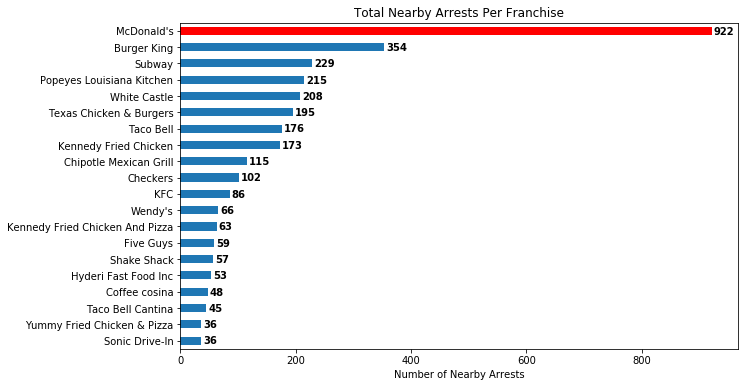

In [324]:
# Bar graph of top twenty fast food restaurants with nearby crimes
# plot.barh() creates horizontal bar plot - easier to read restaurant names
y = restaurants_df['Closest Restaurant'].value_counts().head(20).sort_values(ascending=True)
restaurant_count = y.plot.barh(figsize = (10,6))

# Add labels and title
plt.xlabel('Number of Nearby Arrests')
plt.title('Total Nearby Arrests Per Franchise')

# Solution for adding values to bar chart:
# https://stackoverflow.com/questions/53066633/python-how-to-show-values-on-top-of-bar-plot
for i, v in enumerate(y):
    plt.text(v + 3, i - .2, str(v), color='black', fontweight='bold')

# Color only McDonald's bar for reference
restaurant_count.patches[y.index.get_indexer(['McDonald\'s'])[0]].set_facecolor('r')

# Save plot to .png file
plt.savefig('Total_Arrests.png')

plt.show()

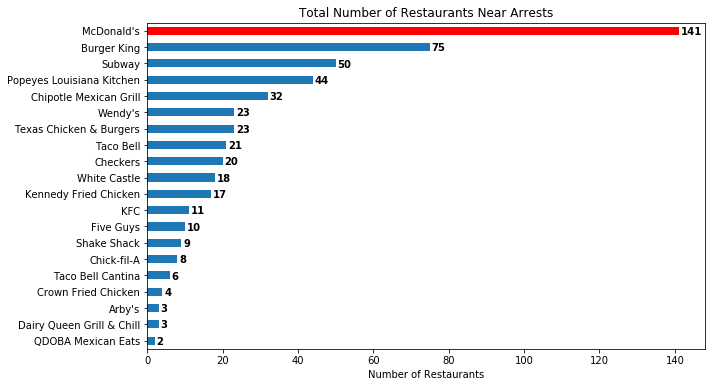

In [325]:
# Find amount of nearby crimes per each unique restaurant
unique_restaurants_df = restaurants_df.drop_duplicates(subset = 'Restaurant Address').reset_index()
y = unique_restaurants_df['Closest Restaurant'].value_counts().head(20).sort_values(ascending=True)
# Plot amount of crimes per each unique restaurant and categorize by franchise on bar chart
restaurant_count = y.plot.barh(figsize = (10,6))

# Add labels and title
plt.xlabel('Number of Restaurants')
plt.title('Total Number of Restaurants Near Arrests')

# Solution for adding values to bar chart:
# https://stackoverflow.com/questions/53066633/python-how-to-show-values-on-top-of-bar-plot
for i, v in enumerate(y):
    plt.text(v + .5, i - .22, str(v), color='black', fontweight='bold')
    
# Color only McDonald's bar for reference
restaurant_count.patches[y.index.get_indexer(['McDonald\'s'])[0]].set_facecolor('r')

# Save plot to .png file
plt.savefig('Total_Restaurants.png')

plt.show()

In [279]:
# Construct a DataFrame that yields a ratio of number of crimes per franchise

# Count the number of crimes per franchise
num_crimes_df = pd.DataFrame(restaurants_df['Closest Restaurant'].value_counts().reset_index())

# Count the number of unique restaurants for each franchise
num_restaurants_df = pd.DataFrame(unique_restaurants_df['Closest Restaurant'].value_counts().reset_index())

# Create DataFrames containing above results
num_crimes_df.columns = ['Restaurant Name','Number of Crimes Nearby']
num_restaurants_df.columns = ['Restaurant Name','Number of Restaurants']

# Merge DataFrames together into on in order to compare numbers
ratio_df = pd.merge(num_crimes_df,num_restaurants_df,on='Restaurant Name')

# Create column that calculates ratio of crimes to restaurants and sort ascending for sake of bar chart
ratio_df['Crime Ratio'] = round(ratio_df['Number of Crimes Nearby']/ratio_df['Number of Restaurants'],2)
dangerous_ratio_df = ratio_df.sort_values('Crime Ratio', ascending=True)

# Isolate restaurants with more than 3 locations to only look at popular restaurants
dangerous_franchises = dangerous_ratio_df.loc[dangerous_ratio_df['Number of Restaurants'] > 3]

dangerous_franchises

,Restaurant Name,Number of Crimes Nearby,Number of Restaurants,Crime Ratio
11,Wendy's,66,23,2.87
24,Chick-fil-A,25,8,3.12
8,Chipotle Mexican Grill,115,32,3.59
2,Subway,229,50,4.58
1,Burger King,354,75,4.72
3,Popeyes Louisiana Kitchen,215,44,4.89
9,Checkers,102,20,5.10
13,Five Guys,59,10,5.90
25,Crown Fried Chicken,24,4,6.00
14,Shake Shack,57,9,6.33


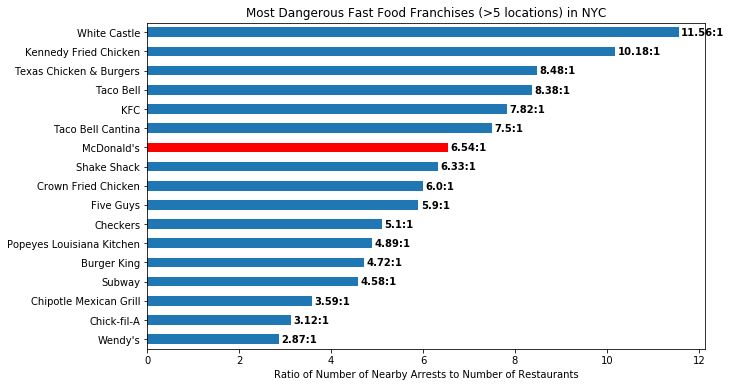

In [327]:
# Create DataFrame to use for bar chart
restaurant_plot = dangerous_franchises[['Restaurant Name', 'Crime Ratio']]

# Plot bar graph of most dangerous restaurants in NYC by franchise
a = restaurant_plot.plot.barh('Restaurant Name','Crime Ratio', figsize = (10,6), legend=None)
a

# Assign variable for enumerate functions
y = restaurant_plot['Crime Ratio']

# Add labels and title
plt.ylabel('')
plt.xlabel('Ratio of Number of Nearby Arrests to Number of Restaurants')
plt.title('Most Dangerous Fast Food Franchises (>5 locations) in NYC')

# Solution for adding values to bar chart:
# https://stackoverflow.com/questions/53066633/python-how-to-show-values-on-top-of-bar-plot
for i, v in enumerate(y):
    plt.text(v + .05, i - .17, str(f'{v}:1'), color='black', fontweight='bold')
    
# Color only McDonald's bar for reference
# Source code: https://stackoverflow.com/questions/48547697/change-colour-of-bars-based-on-string-value
for i,b in enumerate(y):
    if b:
        a.patches[10].set_facecolor('red')
    
# Save plot to .png file
plt.savefig('Most_Dangerous.png')

plt.show()